#  Imports

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
import albumentations.pytorch as albu_pt
%matplotlib inline

import apex
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import pytorch_tools as pt

from src.dataset import OpenCitiesDataset, OpenCitiesTestDataset, InriaTilesDataset
from src.augmentations import get_aug
from src.callbacks import ThrJaccardScore
from pytorch_tools.fit_wrapper.callbacks import SegmCutmix

In [3]:
import yaml
from src.utils import MODEL_FROM_NAME
from pytorch_tools.fit_wrapper.callbacks import Callback
from pytorch_tools.utils.misc import to_numpy

# Get dataloaders

In [4]:
SZ = 384
BS = 16
BUILDINGS_ONLY = True

aug = get_aug("medium", SZ)

val_aug = get_aug("val", SZ)

test_aug = get_aug("test", SZ)

val_dtst = OpenCitiesDataset(split="val", transform=val_aug, buildings_only=BUILDINGS_ONLY)
val_dtld = DataLoader(val_dtst, batch_size=BS, shuffle=False, num_workers=4, drop_last=True)
val_dtld_i = iter(val_dtld)

train_dtst = OpenCitiesDataset(split="train", transform=aug, buildings_only=BUILDINGS_ONLY)
train_dtld = DataLoader(train_dtst, batch_size=BS, shuffle=True, num_workers=8, drop_last=True)
train_dtld_i = iter(train_dtld)

test_dtst = OpenCitiesTestDataset(transform=test_aug)
test_dtld = DataLoader(test_dtst, batch_size=BS, shuffle=False, num_workers=8, drop_last=False)
test_dtld_i = iter(test_dtld)

In [34]:
val_dtst_inria = InriaTilesDataset(split="val", transform=val_aug)
val_dtld_inria = DataLoader(val_dtst_inria, batch_size=BS, shuffle=True, num_workers=8, drop_last=True)

train_dtst_inria = InriaTilesDataset(split="train", transform=aug)
train_dtld_inria = DataLoader(train_dtst_inria, batch_size=BS, shuffle=True, num_workers=8, drop_last=True)

In [35]:
class ToCudaLoader:
    def __init__(self, loader):
        self.loader = loader
        
    def __iter__(self):
        return ((img.cuda(), target.cuda()) for img, target in self.loader)
    
    def __len__(self):
        return len(self.loader)
    
val_dtld_gpu = ToCudaLoader(val_dtld)
train_dtld_gpu = ToCudaLoader(train_dtld)
val_dtld_inria_gpu = ToCudaLoader(val_dtld_inria)
train_dtld_inria_gpu = ToCudaLoader(train_dtld_inria)

In [7]:
len(train_dtst), len(val_dtst), len(test_dtst)

(10691, 1383, 11481)

In [8]:
len(train_dtst_inria), len(val_dtst_inria)

(26195, 1225)

In [9]:
img, mask = train_dtst[1]
img.shape, mask.shape

(torch.Size([3, 384, 384]), torch.Size([1, 384, 384]))

In [10]:
img, mask = train_dtst_inria[1]
img.shape, mask.shape

(torch.Size([3, 384, 384]), torch.Size([1, 384, 384]))

In [11]:
# plt.imshow(mask[2])

In [12]:
test_dtst[0][0].shape, test_dtst[0][1].shape

((1024, 1024, 3), torch.Size([3, 1024, 1024]))

In [20]:
# val_dtld_i = iter(val_dtld_inria)
val_dtld_i = iter(val_dtld)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


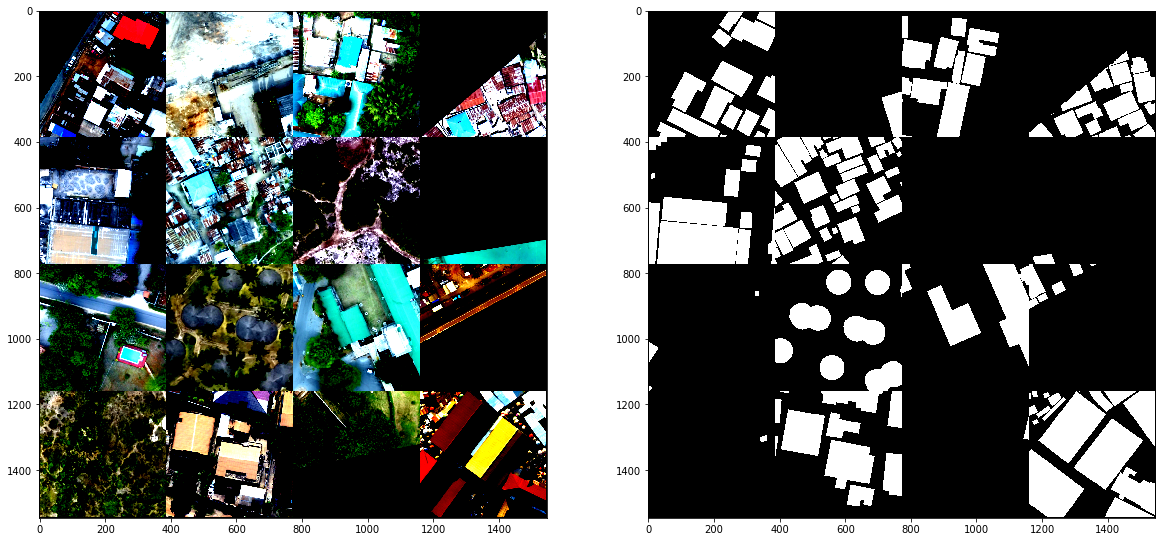

In [29]:
# batch = next(val_dtld_i)
imgs, masks = next(val_dtld_i)
# imgs, masks = SegmCutmix(1, 1).cutmix(imgs, masks) # test cutmix
# (_, imgs, _), (_, masks, _) = next(test_dtld_i), next(test_dtld_i) 
# preds = model(imgs.cuda()).cpu().detach()
# imgs = preds.sigmoid()
imgs_grid = make_grid(imgs, nrow=4).transpose(0,2)#.transpose(0,1)
masks_grid = make_grid(masks, nrow=4).transpose(0,2)#.transpose(0,1)
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(imgs_grid)
axes[1].imshow(masks_grid);

# Model training

In [30]:
from bloodaxe_models import get_model as get_ba_model

In [36]:
# model = pt.segmentation_models.DeepLabV3(
#     'se_resnet50', output_stride=16, num_classes=1
# ).cuda()
# model = pt.segmentation_models.Unet(
#     'se_resnet50', num_classes=1 if BUILDINGS_ONLY else 3
# ).cuda()
# model = get_ba_model("hrnet34_unet64").cuda()
# model = get_ba_model("resnet34_fpncat128").cuda()
model = pt.segmentation_models.SegmentationFPN('resnet34', num_classes=1, merge_policy="add").cuda()
# optim = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
optim = apex.optimizers.FusedNovoGrad(model.parameters(), weight_decay=1e-5)
model, optim = apex.amp.initialize(model, optim, verbosity=0, loss_scale=2048)
# freeze encoder
# for p in model.encoder.parameters():
#     p.requires_grad = False
pt.utils.misc.count_parameters(model)

(23154624, 23154624)

In [37]:
loss = pt.losses.JaccardLoss(mode="binary").cuda()
loss = 0.5 * pt.losses.CrossEntropyLoss(mode="binary").cuda() + 0.5 * loss
# loss = 0.5 * loss + 0.5 * pt.losses.BinaryFocalLoss().cuda() 
# loss = pt.losses.BinaryFocalLoss().cuda() 
# loss = pt.losses.LovaszLoss().cuda() + 4 * pt.losses.BinaryFocalLoss().cuda() 

In [38]:
bce_metric = pt.losses.CrossEntropyLoss(mode="binary").cuda()
bce_metric.name = "BCE"

In [39]:
runner = pt.fit_wrapper.Runner(
    model, 
    optim, 
    criterion=loss,
    callbacks=[
#         pt.fit_wrapper.callbacks.Timer(),
        pt.fit_wrapper.callbacks.ConsoleLogger(), 
#         PatchTarget(), # needed for bloodaxe models
#         pt.fit_wrapper.callbacks.ReduceLROnPlateau(10),
#         pt.fit_wrapper.callbacks.FileLogger('/tmp/')
    ],
    metrics=[pt.metrics.JaccardScore(mode="binary"), bce_metric, ThrJaccardScore()],
)

In [40]:
# imgs, masks = next(iter(val_dtld_gpu))
# pred = model(imgs)
# imgs.dtype, masks.dtype, imgs.shape, masks.shape, pred.shape

In [ ]:
runner.fit(val_dtld_inria_gpu, val_loader=val_dtld_inria_gpu, epochs=100)

Epoch  1/100. training: 77it [00:06, 11.88it/s, BCE=0.621, Jaccard=0.118, Loss=0.7516, ThrJaccard@0.5=0.117]            
Epoch  1/100. validating: 77it [00:03, 19.35it/s, BCE=0.579, Jaccard=0.126, Loss=0.7265, ThrJaccard@0.5=0.142]            
Epoch  2/100. training: 77it [00:06, 12.00it/s, BCE=0.521, Jaccard=0.131, Loss=0.6947, ThrJaccard@0.5=0.156]            
Epoch  2/100. validating: 77it [00:03, 20.31it/s, BCE=0.467, Jaccard=0.145, Loss=0.6614, ThrJaccard@0.5=0.185]            
Epoch  3/100. training: 77it [00:06, 11.93it/s, BCE=0.439, Jaccard=0.152, Loss=0.6437, ThrJaccard@0.5=0.198]            
Epoch  3/100. validating: 77it [00:03, 20.10it/s, BCE=0.410, Jaccard=0.168, Loss=0.6209, ThrJaccard@0.5=0.233]            
Epoch  4/100. training:  62% 47/76 [00:04<00:02, 13.61it/s, BCE=0.389, Jaccard=0.172, Loss=0.6085, ThrJaccard@0.5=0.230]

In [28]:
runner.fit(train_dtld_gpu, val_loader=val_dtld_gpu, epochs=30)

Epoch  1/30. training: 669it [00:58, 11.47it/s, BCE=0.202, Jaccard=0.698, Loss=0.1901]             
Epoch  1/30. validating: 87it [00:09,  9.43it/s, BCE=0.193, Jaccard=0.661, Loss=0.1988]            
Epoch  2/30. training: 669it [00:58, 11.48it/s, BCE=0.201, Jaccard=0.700, Loss=0.1890]             
Epoch  2/30. validating: 87it [00:08,  9.79it/s, BCE=0.191, Jaccard=0.660, Loss=0.1982]            
Epoch  3/30. training: 669it [00:58, 11.44it/s, BCE=0.202, Jaccard=0.699, Loss=0.1895]             
Epoch  3/30. validating: 87it [00:09,  9.43it/s, BCE=0.192, Jaccard=0.664, Loss=0.1974]            
Epoch  4/30. training: 669it [00:58, 11.46it/s, BCE=0.201, Jaccard=0.699, Loss=0.1894]             
Epoch  4/30. validating: 87it [00:09,  9.62it/s, BCE=0.189, Jaccard=0.662, Loss=0.1967]            
Epoch  5/30. training: 669it [00:58, 11.45it/s, BCE=0.200, Jaccard=0.700, Loss=0.1884]             
Epoch  5/30. validating: 87it [00:08, 10.05it/s, BCE=0.190, Jaccard=0.665, Loss=0.1960]            


KeyboardInterrupt: 

In [16]:
runner.fit(val_dtld_gpu, val_loader=val_dtld_gpu, epochs=30)

Epoch  1/30. training: 87it [00:09,  9.49it/s, Jaccard=0.511, Loss=0.4885]            
Epoch  1/30. validating: 87it [00:09,  9.49it/s, Jaccard=0.567, Loss=0.4327]            
Epoch  2/30. training: 87it [00:09,  9.45it/s, Jaccard=0.626, Loss=0.3737]            
Epoch  2/30. validating: 87it [00:09,  9.55it/s, Jaccard=0.649, Loss=0.3509]            
Epoch  3/30. training: 87it [00:09,  9.57it/s, Jaccard=0.659, Loss=0.3414]            
Epoch  3/30. validating: 87it [00:09,  9.56it/s, Jaccard=0.672, Loss=0.3279]            
Epoch  4/30. training: 87it [00:09,  9.09it/s, Jaccard=0.692, Loss=0.3077]            
Epoch  4/30. validating: 87it [00:09,  9.42it/s, Jaccard=0.700, Loss=0.3001]            
Epoch  5/30. training: 87it [00:09,  9.40it/s, Jaccard=0.700, Loss=0.2997]            
Epoch  5/30. validating: 87it [00:09,  9.50it/s, Jaccard=0.718, Loss=0.2824]            
Epoch  6/30. training: 87it [00:09,  9.59it/s, Jaccard=0.723, Loss=0.2773]            
Epoch  6/30. validating: 87it [00

KeyboardInterrupt: 

In [ ]:
for p in model.parameters():
    p.requires_grad = True

In [ ]:
runner.fit(val_dtld_gpu, val_loader=val_dtld_gpu, epochs=30)

# Results examination

In [6]:
# log_path = "logs/fpn_sm_cat_seresnet50_20200208_190143/"
# log_path = "logs/fpn_sm_20200205_165954/" # 0.71 on LB. 0.67 on local per image
# log_path = "logs/deeplab_small_dilation_seresnet50_20200209_112059/" # 0.72 on local val
log_path = "logs/fpn_nov_bce_dice_seresnet50_20200209_235106/"
config = yaml.load(open(log_path + "config.yaml"))
model = MODEL_FROM_NAME[config["segm_arch"]](config["arch"], **config.get("model_params", {})).cuda()
print("model loaded")
model.load_state_dict(torch.load(log_path + 'model.chpn')["state_dict"])

model loaded


<All keys matched successfully>

In [7]:
# torch.onnx.export(model, torch.ones(1, 3, 256, 256).cuda(), "model.onnx")

In [8]:
model = apex.amp.initialize(model, verbosity=0)

In [9]:
val_dtld = DataLoader(val_dtst, batch_size=1, shuffle=False, num_workers=2, drop_last=True)
val_dtld_gpu = ToCudaLoader(val_dtld)

In [12]:
val_dtld = DataLoader(val_dtst, batch_size=16, shuffle=False, num_workers=4, drop_last=True)
val_dtld_gpu = ToCudaLoader(val_dtld)

In [13]:
class ResultsHist(Callback):
    """Saves all values of loss"""
    def __init__(self):
        super().__init__()
        self.res = []
        
    def on_batch_end(self):
        data, target = self.state.input
        output = self.state.output
        loss = self.state.metrics[0](output, target)
        self.res.append(to_numpy(loss))
    
    def on_loader_end(self):
        self.res = np.array(self.res)
        
class PredSaver(Callback):
    """Saves best and worse predicts"""
    def __init__(self, best_thr=0.9, worst_thr=0.2, filter_empty=True):
        super().__init__()
        self.best_img = []
        self.best_target = []
        self.best_preds = []
        self.best_metric = []
        
        self.worst_img = []
        self.worst_target = []
        self.worst_preds = []
        self.worst_metric = []
        
        self.best_thr = best_thr
        self.worst_thr = worst_thr
        self.filter_empty = filter_empty
        
    def on_batch_end(self):
        data, target = self.state.input
        output = self.state.output
        metric = self.state.metrics[0](output, target)
        metric = to_numpy(metric)
        if metric > self.best_thr:
            if self.filter_empty and to_numpy(target).sum() == 0:
                return 
            self.best_img.append(to_numpy(data))
            self.best_target.append(to_numpy(target))
            self.best_preds.append(to_numpy(output))
            self.best_metric.append(metric)
        
        if metric < self.worst_thr:
            self.worst_img.append(to_numpy(data))
            self.worst_target.append(to_numpy(target))
            self.worst_preds.append(to_numpy(output))
            self.worst_metric.append(metric)
#         self.res.append(pt.utils.misc.to_numpy(metric))
    
    def on_loader_end(self):
        if len(self.worst_img) > 0:
            self.worst_img = np.swapaxes(np.array(self.worst_img).squeeze(), 1, 3)
            self.worst_img = np.swapaxes(self.worst_img, 1, 2)
            self.worst_target = np.array(self.worst_target).squeeze()
            self.worst_preds = np.array(self.worst_preds).squeeze()
            self.worst_metric = np.array(self.worst_metric)
        
        if len(self.best_img) > 0:
            self.best_img = np.swapaxes(np.array(self.best_img).squeeze(), 1, 3)
            self.best_img = np.swapaxes(self.best_img, 1, 2)
            self.best_target = np.array(self.best_target).squeeze()
            self.best_preds = np.array(self.best_preds).squeeze()
            self.best_metric = np.array(self.best_metric)
    
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

In [16]:
loss = pt.losses.JaccardLoss()
results_hist = ResultsHist()
pred_saver = PredSaver(worst_thr=0.2, best_thr=0.8)
runner = pt.fit_wrapper.Runner(
    model, 
    None, 
    criterion=loss,
    callbacks=[
        pt.fit_wrapper.callbacks.ConsoleLogger(),
        results_hist,
        pred_saver,
    ],
    metrics=[
        pt.metrics.JaccardScore(mode="binary"),
        ThrJaccardScore(thr=0.4),
#         ThrJaccardScore(thr=0.3),
#         ThrJaccardScore(thr=0.4),
    ]
)
runner.evaluate(val_dtld_gpu)

Epoch  1/1. validating: 87it [00:05, 15.78it/s, Jaccard=0.675, Loss=0.3245, ThrJaccard@0.4=0.715]            


(0.32452744245529175, [0.6754725575447083, 0.7153637568617977])

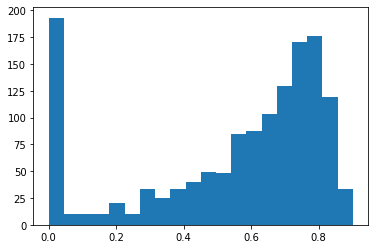

In [59]:
plt.hist(results_hist.res, bins=20);

In [61]:
len(pred_saver.worst_preds)

232

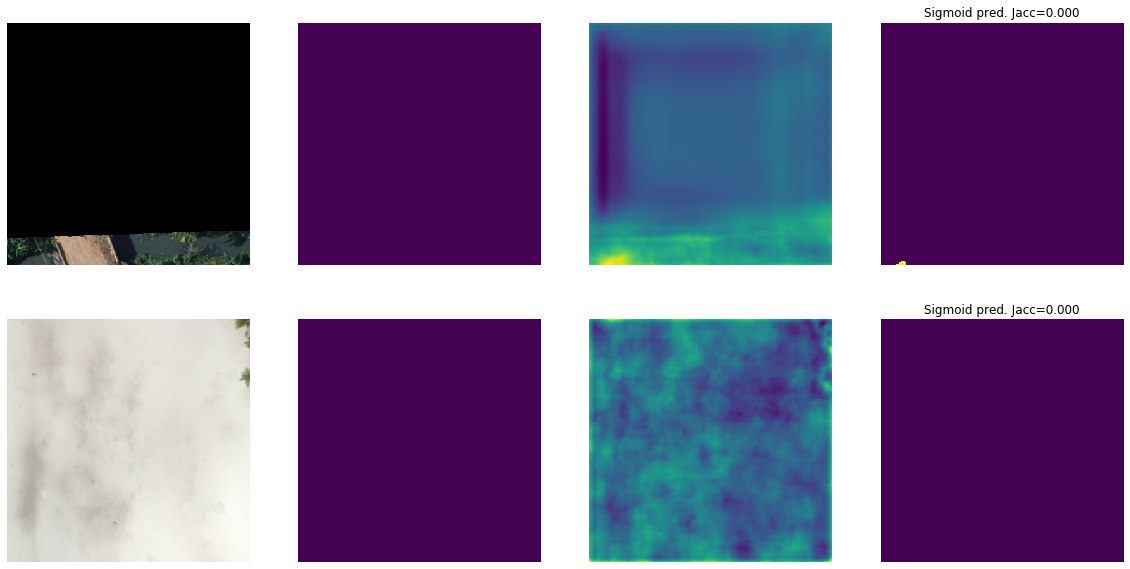

In [75]:
# Worst predictions
N_ROW = 2
fig, axes = plt.subplots(N_ROW, 4, figsize=(20, 10))
for i in axes:
    for j in i:
        j.axis('off')
for i in range(N_ROW):
    N = np.random.randint(0, len(pred_saver.worst_preds))
    img = pred_saver.worst_img[N] * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    axes[i][0].imshow((img * 255).astype(np.uint8))
    axes[i][1].imshow(pred_saver.worst_target[N])
    axes[i][2].imshow(pred_saver.worst_preds[N])
    axes[i][3].imshow(sigmoid(pred_saver.worst_preds[N]) > 0.6)
    axes[i][3].set_title(f"Sigmoid pred. Jacc={pred_saver.worst_metric[N]:.03f}")
    

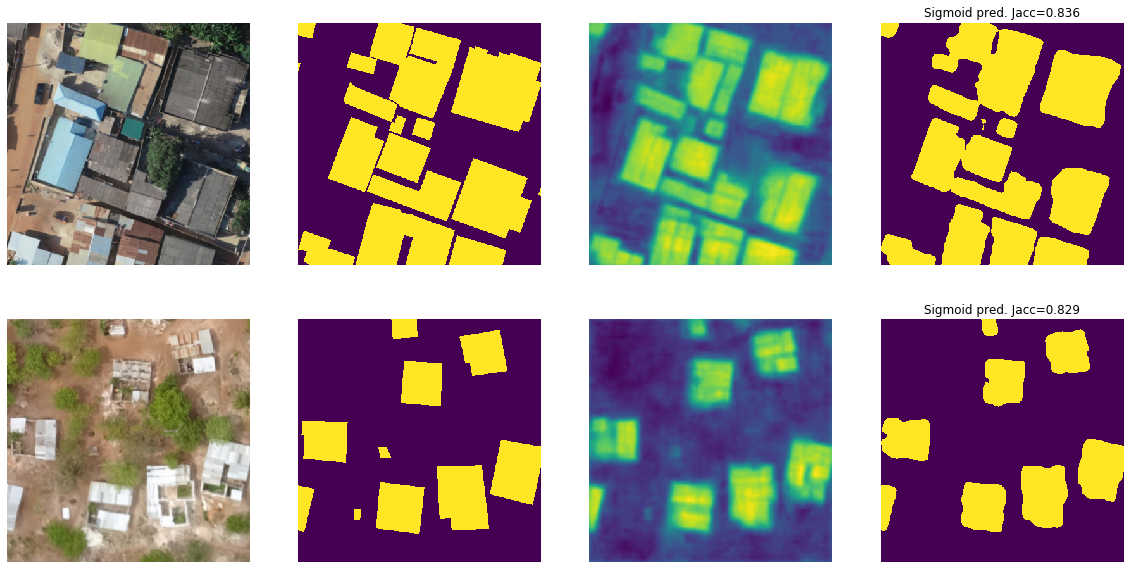

In [78]:
# Best predictions
N_ROW = 2
fig, axes = plt.subplots(N_ROW, 4, figsize=(20, 10))
for i in axes:
    for j in i:
        j.axis('off')
for i in range(N_ROW):
    N = np.random.randint(0, len(pred_saver.best_preds))
    img = pred_saver.best_img[N] * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    axes[i][0].imshow((img * 255).astype(np.uint8))
    axes[i][1].imshow(pred_saver.best_target[N])
    axes[i][2].imshow(pred_saver.best_preds[N])
    axes[i][3].imshow(sigmoid(pred_saver.best_preds[N]) > 0.6)
    axes[i][3].set_title(f"Sigmoid pred. Jacc={pred_saver.best_metric[N]:.03f}")
    

# Looking for bugs

In [6]:
from bloodaxe_models import get_model as get_ba_model
model_ba = get_ba_model("resnet34_fpncat128")
model_my = pt.segmentation_models.SegmentationFPN('resnet34', num_classes=1)
INP = torch.ones(2, 3, 256, 256)

In [7]:
pt.utils.misc.count_parameters(model_ba), pt.utils.misc.count_parameters(model_my)

((22590789, 22590789), (23154624, 23154624))

In [10]:
[i.shape for i in model_ba.encoder(INP)]

[torch.Size([2, 64, 64, 64]),
 torch.Size([2, 128, 32, 32]),
 torch.Size([2, 256, 16, 16]),
 torch.Size([2, 512, 8, 8])]

In [11]:
[i.shape for i in model_my.encoder(INP)]

[torch.Size([2, 512, 8, 8]),
 torch.Size([2, 256, 16, 16]),
 torch.Size([2, 128, 32, 32]),
 torch.Size([2, 64, 64, 64]),
 torch.Size([2, 64, 128, 128])]

In [21]:
out1 = model_ba.encoder(INP)[-1] - model_my.encoder(INP)[0]

In [25]:
model_ba

FPNCatSegmentationModel(
  (encoder): Resnet34Encoder(
    (layer0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act0): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): 